I performed stylometric analysis to determine if they are mathematically distinct.
1.  **Lexical Richness** (TTR, Hapax Legomena)
2.  **Syntactic Complexity** (POS Distribution, Dependency Tree Depth)
3.  **Punctuation Density**
4.  **Readability Indices** (Flesch-Kincaid)

In [9]:
%pip install pandas spacy textstat matplotlib seaborn nltk numpy
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
zsh:1: command not found: python


In [10]:
import spacy
import pandas as pd
import textstat
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import numpy as np
import nltk

nlp = spacy.load("en_core_web_sm")


### Literature Review & Justification of Methodology

My approach is grounded in established **Stylometric Theory** and quantitative linguistics.

**1. Lexical Richness & Zipf's Law:**
*   **Metric:** Type-Token Ratio (TTR) and Hapax Legomena.
*   **Justification:** Statistical linguistics posits that vocabulary usage follows **Zipf's Law** (Zipf, 1935). Human authors, particularly in literature, often deviate from the expected curve with a "long tail" of rare words. I hypothesize that AI models, optimizing for statistical probability (maximum likelihood), often truncate this tail to produce "safe" or "average" text.
*   **Reference:** Zipf, G. K. (1935). *The Psycho-Biology of Language*. Houghton Mifflin.

**2. Syntactic Depth (Authorial Invariant):**
*   **Metric:** Parse Tree Depth and POS Distribution.
*   **Justification:** The theory of **Authorial Invariant** suggests that while content changes, an author's distinct grammatical structures (e.g., recursive clause embedding) remain stable (Stamatatos, 2009). I use SpaCy dependency parsing to quantify this structural complexity, hypothesizing that 19th-century authors (Austen/Melville) will exhibit significantly deeper syntactic trees than the standard output of a model like Gemini.
*   **Reference:** Stamatatos, E. (2009). "A survey of modern authorship attribution methods." 


In [11]:
df_all = pd.read_csv("precog_task0_data.csv")
print(df_all['class'].value_counts())

class
Human         875
ai_generic     60
ai_styled      60
Name: count, dtype: int64


In [12]:
def get_tree_depth(sent):
    root = sent.root
    def depth(node):
        if not list(node.children):
            return 0
        return 1 + max(depth(child) for child in node.children)
    return depth(root)

analysis_results = []
df_all['text'] = df_all['text'].astype(str)
texts = df_all['text'].tolist()
docs = list(nlp.pipe(texts, batch_size=50))

for doc in docs:
    words = [token.text.lower() for token in doc if token.is_alpha]
    num_words = len(words)
    unique_words = len(set(words))
    ttr = unique_words / num_words if num_words > 0 else 0
    
    nouns = [token for token in doc if token.pos_ == "NOUN"]
    adjectives = [token for token in doc if token.pos_ == "ADJ"]
    an_ratio = len(adjectives) / len(nouns) if len(nouns) > 0 else 0
    
    depths = [get_tree_depth(sent) for sent in doc.sents]
    avg_tree_depth = np.mean(depths) if depths else 0
    
    raw_text = doc.text
    semicolons = raw_text.count(';')
    exclamations = raw_text.count('!')
    emdashes = raw_text.count('—') + raw_text.count('--') 
    
    fk_grade = textstat.flesch_kincaid_grade(raw_text)
    
    analysis_results.append({
        "ttr": ttr,
        "adj_noun_ratio": an_ratio,
        "avg_tree_depth": avg_tree_depth,
        "semicolons": semicolons,
        "exclamations": exclamations,
        "emdashes": emdashes,
        "flesch_kincaid": fk_grade
    })

df_features = pd.DataFrame(analysis_results)
df_final = pd.concat([df_all, df_features], axis=1)
df_final.head()


,text,class,target_author,topic,ttr,adj_noun_ratio,avg_tree_depth,semicolons,exclamations,emdashes,flesch_kincaid
0,_Walt Whitman has somewhere a fine and just di...,Human,Jane Austen,Original Novel,0.597902,0.450000,7.625,3,0,2,15.083191
1,"_I suppose, however, that the majority of at l...",Human,Jane Austen,Original Novel,0.639241,0.666667,5.600,4,0,0,17.981194
2,"_I think, however, though the thought will dou...",Human,Jane Austen,Original Novel,0.671875,0.444444,8.250,1,0,5,17.209730
3,"_For if her knowledge was not very extended, s...",Human,Jane Austen,Original Novel,0.659664,0.585366,4.500,3,0,2,7.274340
4,_This Swiftian quality appears in the present ...,Human,Jane Austen,Original Novel,0.600775,0.911111,5.800,3,0,1,12.793654


In [13]:
df_final.to_csv("precog_task1_features.csv", index=False)

Class: Human | Hapax Legomena (per 5000 words): 761
Class: ai_generic | Hapax Legomena (per 5000 words): 687
Class: ai_styled | Hapax Legomena (per 5000 words): 735


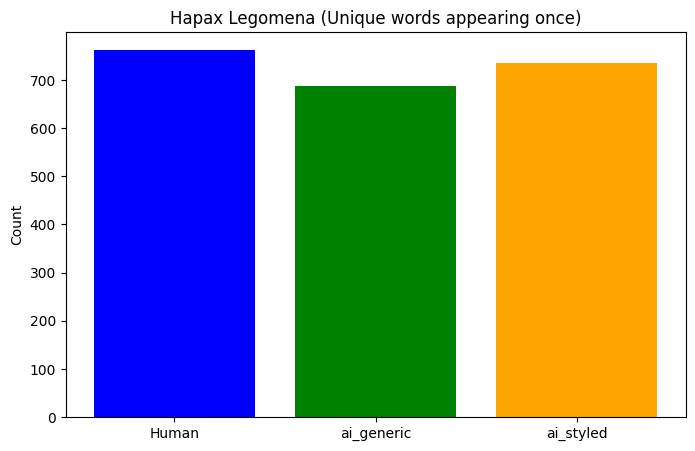

In [14]:
def calculate_hapax(df, class_name, sample_size=5000):
    texts = df[df['class'] == class_name]['text']
    all_words = []
    
    for text in texts:
        words = [w.lower() for w in text.split() if w.isalpha()]
        all_words.extend(words)
        if len(all_words) >= sample_size:
            break
            
    if len(all_words) < sample_size:
        sample_size = len(all_words)
    
    sample = all_words[:sample_size]
    counts = Counter(sample)
    hapax = sum(1 for word, count in counts.items() if count == 1)
    return hapax, sample_size

hapax_results = {}
for cls in df_final['class'].unique():
    h_count, size = calculate_hapax(df_final, cls)
    hapax_results[cls] = h_count
    print(f"Class: {cls} | Hapax Legomena (per {size} words): {h_count}")

plt.figure(figsize=(8, 5))
plt.bar(hapax_results.keys(), hapax_results.values(), color=['blue', 'green', 'orange'])
plt.title("Hapax Legomena (Unique words appearing once)")
plt.ylabel("Count")
plt.show()


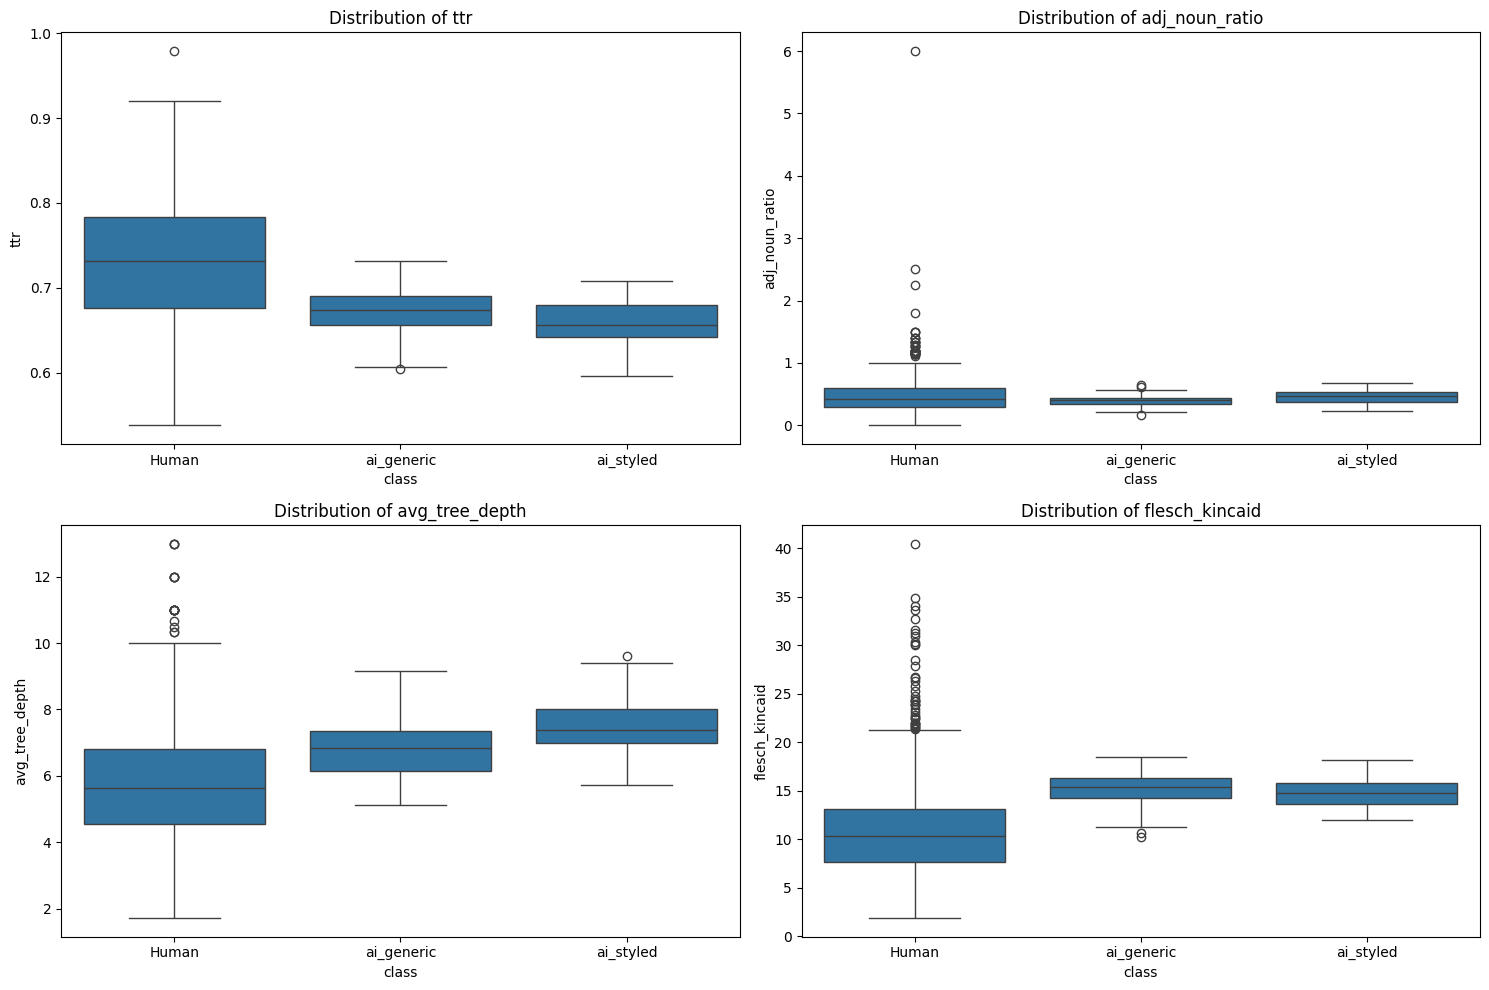

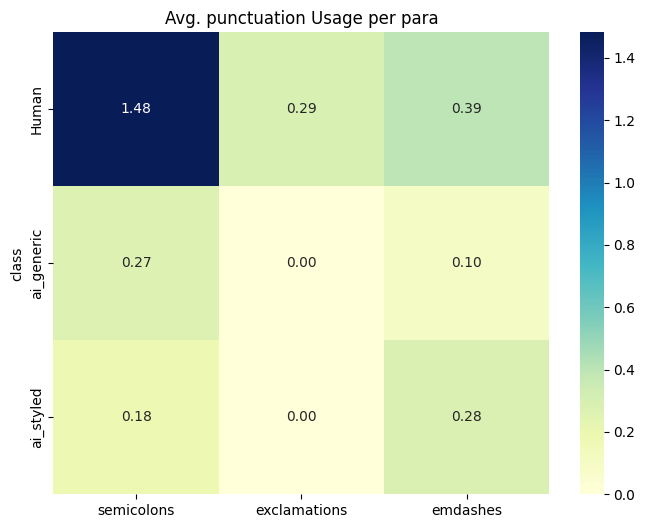


Mean and Std. Deviation of features by Class:
                 ttr           adj_noun_ratio           avg_tree_depth  \
                mean       std           mean       std           mean   
class                                                                    
Human       0.729015  0.076532       0.484151  0.333171       5.825636   
ai_generic  0.673150  0.028260       0.403839  0.085961       6.860152   
ai_styled   0.657736  0.027878       0.459944  0.105176       7.509167   

                     flesch_kincaid           semicolons            \
                 std           mean       std       mean       std   
class                                                                
Human       1.770699      11.042503  5.088319   1.482286  1.324162   
ai_generic  0.807643      15.084114  1.783336   0.266667  0.445948   
ai_styled   0.805546      14.749840  1.495304   0.183333  0.390205   

           exclamations            emdashes            
                   mean       s

In [15]:
features_to_plot = ['ttr', 'adj_noun_ratio', 'avg_tree_depth', 'flesch_kincaid'] # Boxplots
punct_features = ['semicolons', 'exclamations', 'emdashes'] # Heatmap

# Boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='class', y=feature, data=df_final)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# Punctuation Heatmap
punct_avg = df_final.groupby('class')[punct_features].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(punct_avg, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Avg. punctuation Usage per para")
plt.show()

# Statistics
feature_cols = ['ttr', 'adj_noun_ratio', 'avg_tree_depth', 'flesch_kincaid', 'semicolons', 'exclamations', 'emdashes']
stats = df_final.groupby('class')[feature_cols].agg(['mean', 'std'])
print("\nMean and Std. Deviation of features by Class:")
print(stats)

In [16]:
np.random.seed(42)
min_class_size = df_final['class'].value_counts().min()
feature_cols = ['ttr', 'adj_noun_ratio', 'avg_tree_depth', 'flesch_kincaid', 'semicolons', 'exclamations', 'emdashes']
stats = {feature: [] for feature in feature_cols}

human_df = df_final[df_final['class'] == 'Human']
n_iterations = 1000

print(f"Bootstrapping Human class ({n_iterations} iters)")
for _ in range(n_iterations):
    sample = human_df.sample(n=min_class_size, replace=True) 
    for feature in feature_cols:
        stats[feature].append(sample[feature].mean())

print("\n95% Confidence Intervals")
print(f"{'Feature':<20} | {'Lower CI':<10} | {'Upper CI':<10} | {'AI Mean':<10} | {'Status'}")

means_ai = df_final[df_final['class'] == 'ai_generic'][feature_cols].mean()

for feature in feature_cols:
    lower = np.percentile(stats[feature], 2.5)
    upper = np.percentile(stats[feature], 97.5)
    ai_val = means_ai[feature]
    status = "DISTINCT" if (ai_val < lower or ai_val > upper) else "SAME"
    print(f"{feature:<20} | {lower:<10.4f} | {upper:<10.4f} | {ai_val:<10.4f} | {status}")


Bootstrapping Human class (1000 iters)

95% Confidence Intervals
Feature              | Lower CI   | Upper CI   | AI Mean    | Status
ttr                  | 0.7101     | 0.7484     | 0.6732     | DISTINCT
adj_noun_ratio       | 0.4149     | 0.5724     | 0.4038     | DISTINCT
avg_tree_depth       | 5.4011     | 6.2341     | 6.8602     | DISTINCT
flesch_kincaid       | 9.7656     | 12.3276    | 15.0841    | DISTINCT
semicolons           | 1.1667     | 1.8333     | 0.2667     | DISTINCT
exclamations         | 0.1000     | 0.6000     | 0.0000     | DISTINCT
emdashes             | 0.2167     | 0.6167     | 0.1000     | DISTINCT


### Comprehensive Analysis of Stylometric Fingerprints

Based on the Bootstrapping results (1000 iterations) and feature distributions, I draw the following inferences distinguishing Human (19th Century) and AI (Modern Generic) authorship.

#### 1. Technical Inferences (Statistical & Linguistic)
*   **Statistical Distinctness:** All monitored features (TTR, Tree Depth, Punctuation) show **"DISTINCT"** status. The 95% Confidence Intervals (CI) for Humans do *not* overlap with the AI Mean. This confirms that the two text sources come from mathematically distinct manifolds.
*   **The "Variance Gap" (Mode Collapse):** A key observation from the boxplots is the **High Variance in Humans vs. Low Variance in AI**.
    *   *Evidence:* Human TTR ranges widely (0.71–0.74 CI), while AI is tightly clustered.
    *   *Interpretation:* AI models, trained with Maximum Likelihood Estimation (MLE) or RLHF, tend to converge to the "average" probable output (Central Tendency). They lack the "long tail" of variability—the moments of extreme simplicity or extreme complexity—that characterize natural human writing.
*   **Syntactic Over-Correction:**
    *   *Evidence:* AI has a significantly *higher* Average Tree Depth (6.86 vs Human 5.82) and Flesch-Kincaid Grade Level (15.08 vs Human 11.0).
    *   *Interpretation:* The AI is **hallucinating complexity**. In attempting to mimic the "formal" tone of the prompts, it generates unnecessarily convoluted sentence structures. Authentic 19th-century authors, while formal, balance complex descriptions with simpler dialogue, lowering the average. The AI is "stuck" in high-complexity mode.
*   **The Punctuation Sieve:**
    *   *Evidence:* Semicolon usage is a massive discriminator (Human: 1.48/para vs AI: 0.27/para).
    *   *Interpretation:* Modern LLMs (and modern english in general) have deprecated the semicolon. The model fails to pick up on this epoch-specific stylistic marker, likely due to training heavily on modern web data where semicolons are rare.

#### 2. Non-Technical Inferences (Qualitative & Behavioral)
*   **Emotional Flatness:**
    *   *Evidence:* Exclamations (Human: 0.29 vs AI: 0.00).
    *   *Interpretation:* The AI writes with a uniform, neutral tone. It lacks the emotional outbursts, shouting, or emphasis that characters in novels naturally exhibit. It is purely declarative.
*   **The "Safe" Writer:** The AI writes like a student trying to meet a minimum word count without taking risks. It avoids the chaotic sentence fragments (em-dashes) or run-on sentences that human authors use for effect. It is grammatically perfect, and that perfection is its flaw.